In [317]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import manifold
from sklearn import decomposition

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sys
sys.path.append("../graphsage/")

import pandas as pd

from matplotlib import pyplot as plt

In [303]:
from utils import load_data

In [304]:
import numpy as np

In [305]:
from sklearn.metrics import accuracy_score

In [306]:
G, feats, id_map, _, class_map = load_data("/data/ppi/ppi")

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..


**Note: The features are normalized**

In [273]:
train_X, train_y = [], []
test_X, test_y = [], []
val_X, val_y = [], []

for nodeid in G.nodes():
    idx = id_map[nodeid]
    c = class_map[nodeid]
    if G.node[nodeid]['test']:
        test_X.append(feats[idx])
        test_y.append(c)
    elif G.node[nodeid]['val']:
        val_X.append(feats[idx])
        val_y.append(c)
    else:
        train_X.append(feats[idx])
        train_y.append(c)

train_X = torch.Tensor(train_X).float()
test_X = torch.Tensor(test_X).float()
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

In [275]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self ).__init__()
        self.fc1 = nn.Linear(50, 200)
        self.fc3 = nn.Linear(200, 121)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.8)
        X = self.fc3(X)
        #X = F.sigmoid(X)

        return X
    

train_y_ = train_y.float()
test_y_ = test_y.float()

net = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(1000):
    net.train()
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y_)
    loss.backward()
    optimizer.step()
    
net.eval()

print(micro_f1(net(test_X), test_y))

0.539501257663


In [238]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self ).__init__()
        self.fc1 = nn.Linear(50, 200)
        self.fc3 = nn.Linear(200, 121)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.8)
        X = nn.BatchNorm1d(X.shape[1])(X)
        X = self.fc3(X)
        #X = F.sigmoid(X)
        return X
    

train_y_ = train_y.float()
test_y_ = test_y.float()

net = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(1000):
    net.train()
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y_)
    loss.backward()
    optimizer.step()
    
net.eval()

print(micro_f1(net(test_X), test_y))

0.517464856734


In [239]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self ).__init__()
        self.fc1 = nn.Linear(50, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 121)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.8)
        X = F.relu(self.fc2(X))
        X = F.dropout(X, p=0.8)
        X = self.fc3(X)
        #X = F.sigmoid(X)
        return X
    

train_y_ = train_y.float()
test_y_ = test_y.float()

net = Net()

criterion = nn.BCEWithLogitsLoss() # Binary cross entropy (bad for f1)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in range(1000):
    net.train()
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y_)
    loss.backward()
    optimizer.step()
    
net.eval()

print(micro_f1(net(test_X), test_y))

0.557183755699


In [251]:
pred = net(test_X)

In [252]:
pred = torch.round(nn.Sigmoid()(pred)) 

In [253]:
pred_np = np.array(pred.detach())

In [254]:
test_ynp = np.array(test_y)

In [255]:
pred_np.shape

(5524, 121)

In [256]:
test_ynp.shape

(5524, 121)

In [257]:
f1_score(y_pred=pred_np, y_true=test_ynp, average="micro")

0.5571837556992896

In [258]:
f1_score(y_pred=pred_np, y_true=test_ynp, average="macro")

0.3999643415092231

In [161]:
# Todo -- Use f1 as objective
def f1_loss(y_true, y_pred):
    tp = torch.sum(y_true*y_pred, axis=0)
    tp = tp.float()
    tn = torch.sum((1-y_true)*(1-y_pred), axis=0)
    tn = tn.float()
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

(121, 5524)

In [184]:
def micro_f1(logits, labels): 
    # Compute predictions 
    preds = torch.round(nn.Sigmoid()(logits)) 
    # Cast to avoid trouble 
    preds = preds.long()
    labels = labels.long()
    # Count true positives, true negatives, false positives, false negatives 
    tp = torch.nonzero(preds * labels).shape[0] * 1.0
    tn = torch.nonzero((preds - 1) * (labels - 1)).shape[0] * 1.0 
    fp = torch.nonzero(preds * (labels - 1)).shape[0] * 1.0 
    fn = torch.nonzero((preds - 1) * labels).shape[0] * 1.0 
    # Compute micro-f1 score 
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)
    return f1

In [279]:
feats.shape

(56944, 50)

In [278]:
c = 0
for f in feats:
    if sum(f) == 0:
        c += 1
print(c)
print(c/feats.shape[0])

0
0


In [259]:
G, feats, id_map, _, class_map = load_data("/data/reddit/reddit")

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..


In [260]:
len(G)

231443

In [261]:
G.size()

11606919

In [262]:
train_X, train_y = [], []
test_X, test_y = [], []
val_X, val_y = [], []

for nodeid in G.nodes():
    idx = id_map[nodeid]
    c = class_map[nodeid]
    if G.node[nodeid]['test']:
        test_X.append(feats[idx])
        test_y.append(c)
    elif G.node[nodeid]['val']:
        val_X.append(feats[idx])
        val_y.append(c)
    else:
        train_X.append(feats[idx])
        train_y.append(c)
        
train_X = np.array(train_X, dtype=np.float32)
train_y = np.array(train_y, dtype=np.float32)
test_X = np.array(test_X, dtype=np.float32)

train_X = Variable(torch.Tensor(train_X).float())
test_X = Variable(torch.Tensor(test_X).float())
train_y = Variable(torch.Tensor(train_y).long())
test_y = Variable(torch.Tensor(test_y).long())

In [263]:
train_X.shape

torch.Size([152410, 602])

In [264]:
train_y.shape

torch.Size([152410])

In [267]:
test_X.shape, test_y.shape

(torch.Size([55334, 602]), torch.Size([55334]))

In [271]:
torch.mean(train_X[1]), torch.std(train_X[1])

(tensor(0.0031), tensor(0.6128))

In [ ]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self ).__init__()
        self.fc1 = nn.Linear(602, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 121)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.8)
        X = F.relu(self.fc2(X))
        X = F.dropout(X, p=0.8)
        X = self.fc3(X)
        #X = F.sigmoid(X)
        return X
    

train_y_ = train_y.float()
test_y_ = test_y.float()

net = Net()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in range(1000):
    net.train()
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y_)
    loss.backward()
    optimizer.step()

In [287]:
G, feats, id_map, _, class_map = load_data("/data/ppi/ppi", normalize=False)

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..


In [288]:
train_X, train_y = [], []
test_X, test_y = [], []
val_X, val_y = [], []

for nodeid in G.nodes():
    idx = id_map[nodeid]
    c = class_map[nodeid]
    if G.node[nodeid]['test']:
        test_X.append(feats[idx])
        test_y.append(c)
    elif G.node[nodeid]['val']:
        val_X.append(feats[idx])
        val_y.append(c)
    else:
        train_X.append(feats[idx])
        train_y.append(c)

train_X = torch.Tensor(train_X).float()
test_X = torch.Tensor(test_X).float()
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

In [292]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self ).__init__()
        self.fc1 = nn.Linear(50, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 121)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.8)
        X = F.relu(self.fc2(X))
        X = F.dropout(X, p=0.8)
        X = self.fc3(X)
        #X = F.sigmoid(X)
        return X
    

train_y_ = train_y.float()
test_y_ = test_y.float()

net = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in range(1000):
    net.train()
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y_)
    loss.backward()
    optimizer.step()

In [293]:
net.eval()
print(micro_f1(net(test_X), test_y))

0.544178180341


In [298]:
train_Xn, train_y = [], []
test_X, test_y = [], []
val_X, val_y = [], []

for nodeid in G.nodes():
    idx = id_map[nodeid]
    c = class_map[nodeid]
    if G.node[nodeid]['test']:
        test_X.append(feats[idx])
        test_y.append(c)
    elif G.node[nodeid]['val']:
        val_X.append(feats[idx])
        val_y.append(c)
    else:
        train_Xn.append(feats[idx] + np.random.normal(0,1,size=(50,)))
        train_y.append(c)

train_Xn = torch.Tensor(train_Xn).float()
test_X = torch.Tensor(test_X).float()
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

In [299]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self ).__init__()
        self.fc1 = nn.Linear(50, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 121)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.8)
        X = F.relu(self.fc2(X))
        X = F.dropout(X, p=0.8)
        X = self.fc3(X)
        #X = F.sigmoid(X)
        return X
    

train_y_ = train_y.float()
test_y_ = test_y.float()

net = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in range(1000):
    net.train()
    optimizer.zero_grad()
    out = net(train_Xn)
    loss = criterion(out, train_y_)
    loss.backward()
    optimizer.step()
    
net.eval()
print(micro_f1(net(test_X), test_y))

0.360967278543


In [307]:
feats.shape

(56944, 50)

In [310]:
df = pd.DataFrame()

In [315]:
pca = decomposition.PCA(n_components=3)
pca_result = pca.fit_transform(feats)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.04715121 0.03578945 0.03100965]


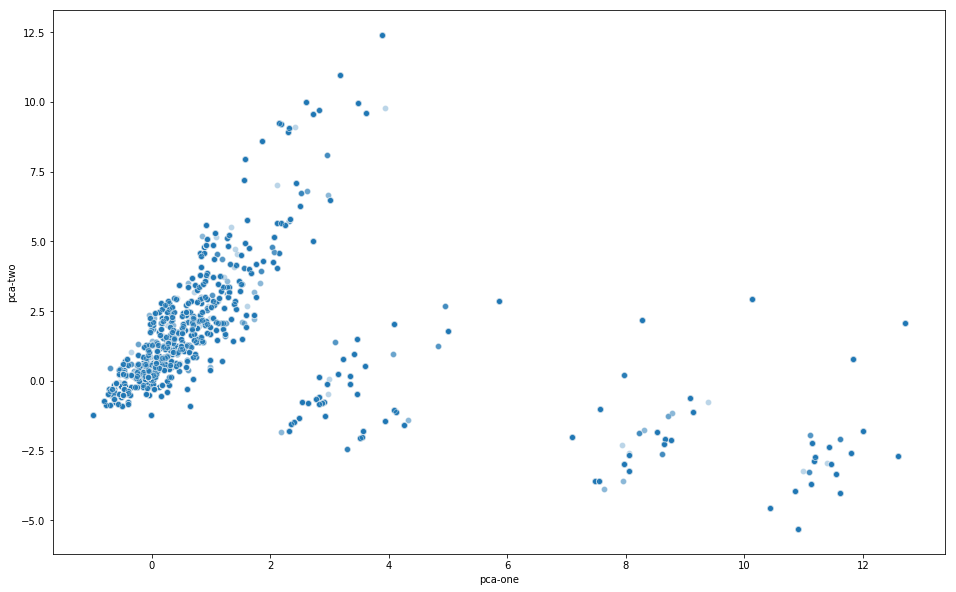

In [319]:
rndperm = np.random.permutation(df.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

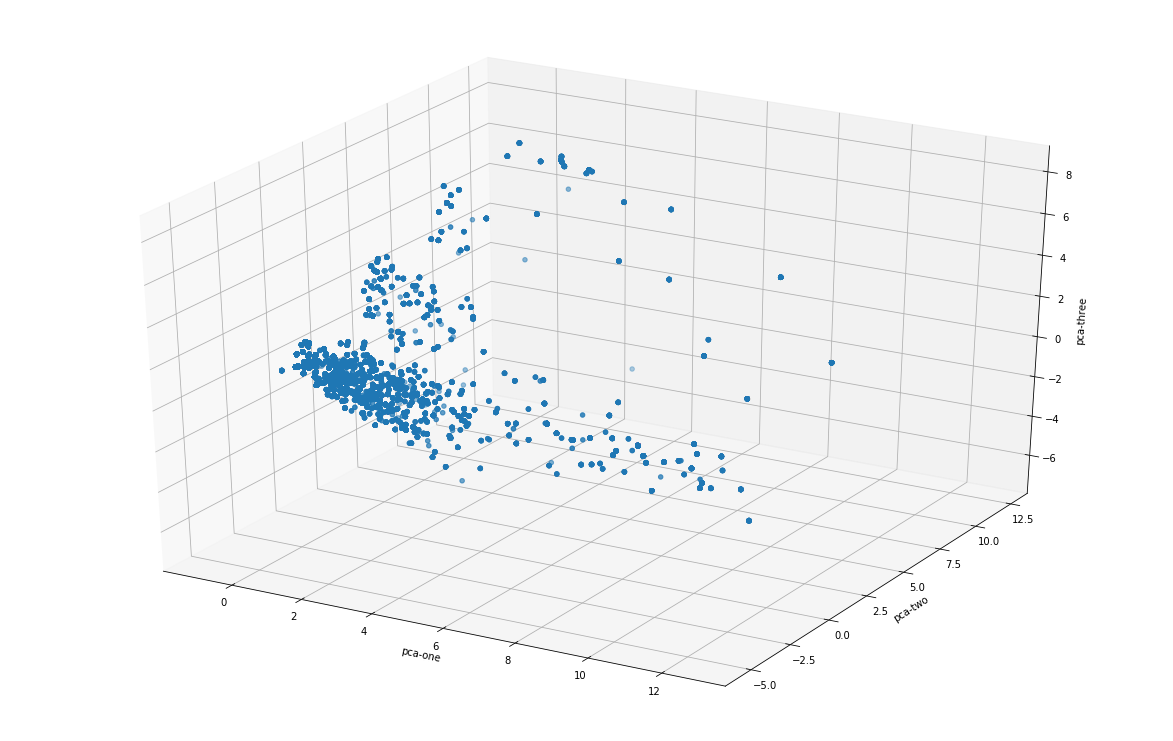

In [322]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 
fig = plt.figure(figsize=(16,10))

ax = Axes3D(fig)
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [324]:
tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 56944 samples in 5.199s...
[t-SNE] Computed neighbors for 56944 samples in 139.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 56944
[t-SNE] Computed conditional probabilities for sample 2000 / 56944
[t-SNE] Computed conditional probabilities for sample 3000 / 56944
[t-SNE] Computed conditional probabilities for sample 4000 / 56944
[t-SNE] Computed conditional probabilities for sample 5000 / 56944
[t-SNE] Computed conditional probabilities for sample 6000 / 56944
[t-SNE] Computed conditional probabilities for sample 7000 / 56944
[t-SNE] Computed conditional probabilities for sample 8000 / 56944
[t-SNE] Computed conditional probabilities for sample 9000 / 56944
[t-SNE] Computed conditional probabilities for sample 10000 / 56944
[t-SNE] Computed conditional probabilities for sample 11000 / 56944
[t-SNE] Computed conditional probabilities for sample 12000 / 56944
[t-SNE] Computed conditional probabilities for 

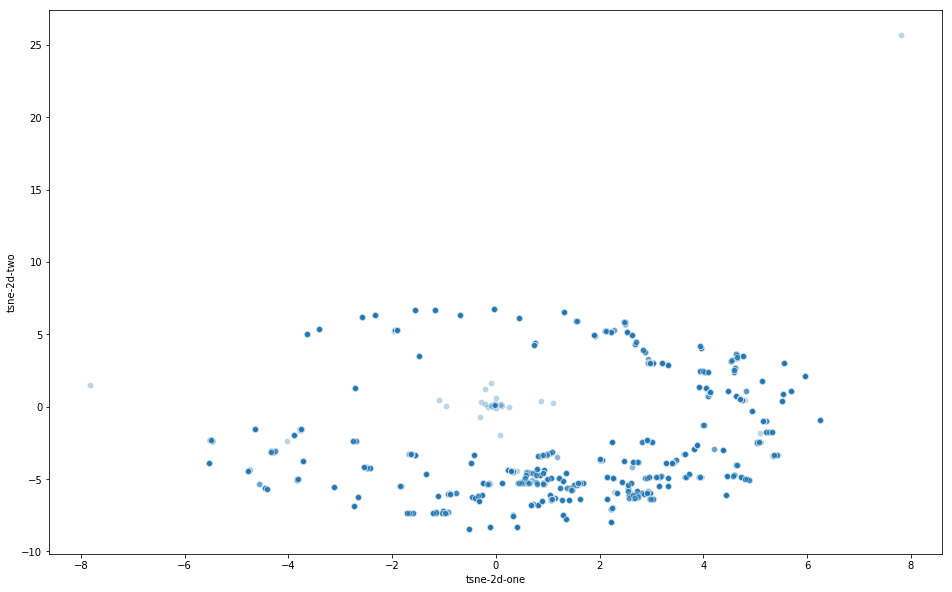

In [326]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [327]:
tsne = manifold.TSNE(n_components=3, verbose=1, perplexity=100, n_iter=500)
tsne_results = tsne.fit_transform(feats)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 56944 samples in 5.102s...
[t-SNE] Computed neighbors for 56944 samples in 150.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 56944
[t-SNE] Computed conditional probabilities for sample 2000 / 56944
[t-SNE] Computed conditional probabilities for sample 3000 / 56944
[t-SNE] Computed conditional probabilities for sample 4000 / 56944
[t-SNE] Computed conditional probabilities for sample 5000 / 56944
[t-SNE] Computed conditional probabilities for sample 6000 / 56944
[t-SNE] Computed conditional probabilities for sample 7000 / 56944
[t-SNE] Computed conditional probabilities for sample 8000 / 56944
[t-SNE] Computed conditional probabilities for sample 9000 / 56944
[t-SNE] Computed conditional probabilities for sample 10000 / 56944
[t-SNE] Computed conditional probabilities for sample 11000 / 56944
[t-SNE] Computed conditional probabilities for sample 12000 / 56944
[t-SNE] Computed conditional probabilities for 

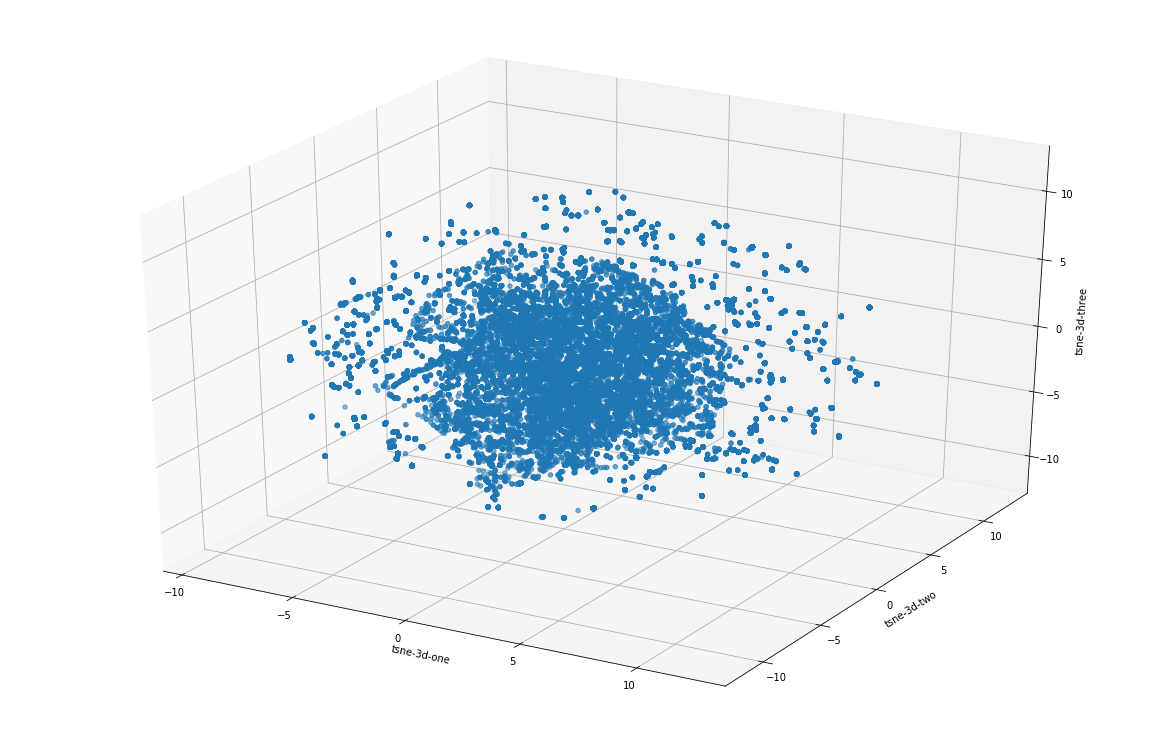

In [328]:
df['tsne-3d-one'] = tsne_results[:,0]
df['tsne-3d-two'] = tsne_results[:,1]
df['tsne-3d-three'] = tsne_results[:,2]
fig = plt.figure(figsize=(16,10))

ax = Axes3D(fig)
ax.scatter(
    xs=df.loc[rndperm,:]["tsne-3d-one"], 
    ys=df.loc[rndperm,:]["tsne-3d-two"], 
    zs=df.loc[rndperm,:]["tsne-3d-three"], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

In [330]:
G, feats, id_map, _, class_map = load_data("/data/cora_gcn/cora")

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..


Explained variation per principal component: [0.00535189 0.00440381 0.00415872]


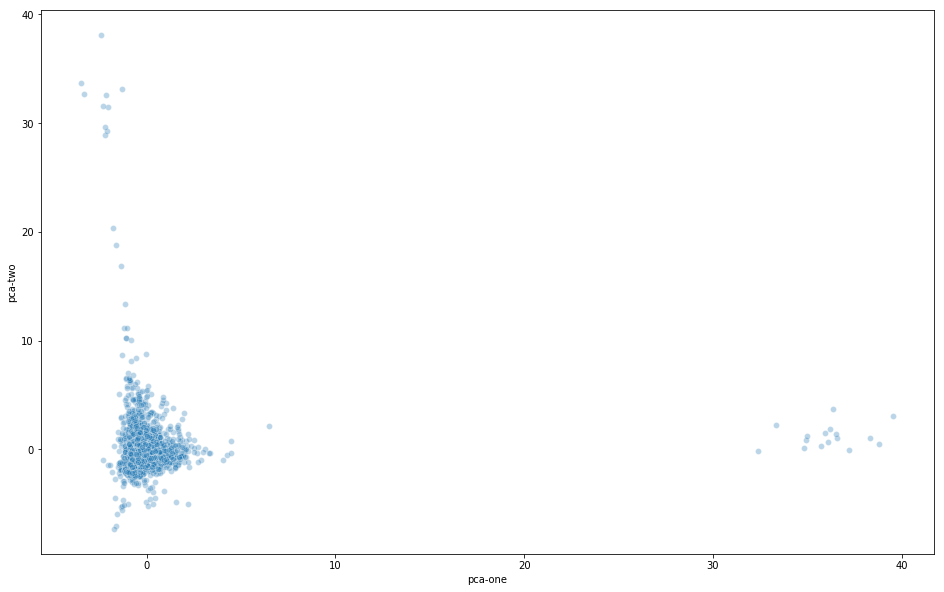

In [331]:
df = pd.DataFrame()
pca = decomposition.PCA(n_components=3)
pca_result = pca.fit_transform(feats)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
rndperm = np.random.permutation(df.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

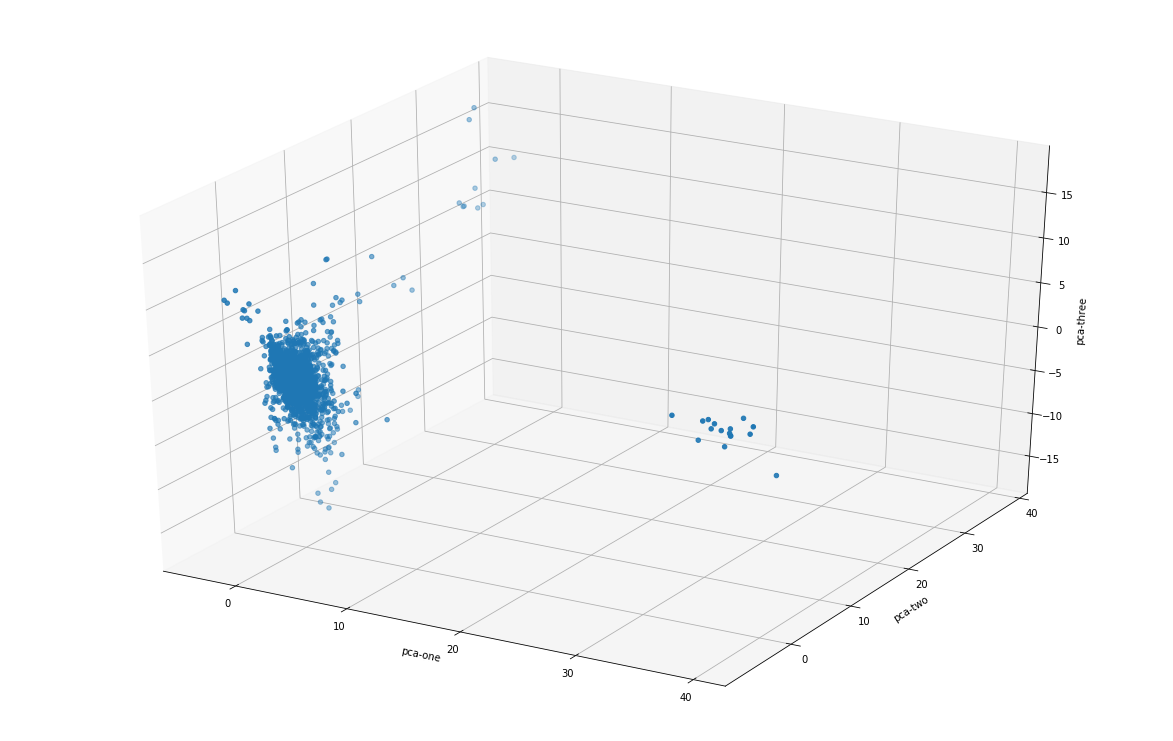

In [333]:
fig = plt.figure(figsize=(16,10))

ax = Axes3D(fig)
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.086s...
[t-SNE] Computed neighbors for 2708 samples in 13.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 6.590937
[t-SNE] KL divergence after 250 iterations with early exaggeration: 134.558670
[t-SNE] Error after 300 iterations: 4.726200


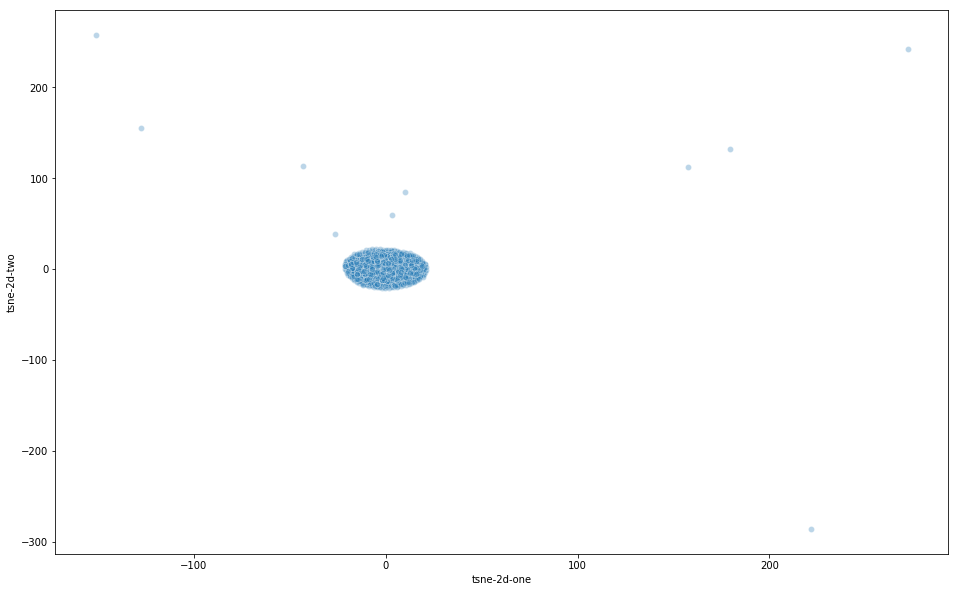

In [332]:
tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [334]:
import networkx as nx

In [340]:
np.sum(nx.degree(G).values()) 

10556

In [339]:
len(G)

2708

In [341]:
10556 / 2708

3

In [342]:
max(nx.degree(G).values())

168